In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%set_env PYTHONBREAKPOINT=IPython.core.debugger.set_trace

env: PYTHONBREAKPOINT=IPython.core.debugger.set_trace


In [2]:
from fastai.vision import *

In [3]:
vcand = np.load('vcand_case2.npy')
nview = 20
viewOrd = []

In [4]:
path = Path('./ModelNet40_20Small')
path.ls()

[PosixPath('ModelNet40_20Small/val'),
 PosixPath('ModelNet40_20Small/test'),
 PosixPath('ModelNet40_20Small/train'),
 PosixPath('ModelNet40_20Small/.ipynb_checkpoints'),
 PosixPath('ModelNet40_20Small/models')]

In [5]:
classes = sorted(os.listdir(path/'train'))

In [6]:
# For the validation dataset, count the number of data points for each class.
# Used to calculate accuracy-per-class during validation.

def directory(path,extension):
    list_dir = []
    list_dir = os.listdir(path)
    count = 0
    for file in list_dir:
        if file.endswith(extension): # eg: '.txt'
            count += 1
    return count

folders = [f.path for f in os.scandir(path/'test') if f.is_dir()]
folders = sorted(folders)
validCount = []
for folds in folders:
    validCount = np.append(validCount, directory(folds, '.png')//20)
validCount = validCount.astype(int)

In [7]:
# u = np.arange(0, 40)
# counts = np.random.randint(low=0, high = 100, size = 40)
# v = [validCount[i] for i in u.astype(int)]
# unique = [classes[i] for i in u.astype(int)]
# corrects = ((counts/v * 100) + 0.5).astype(int) / 100.0
# countDict = dict(zip(unique, corrects))
# countDict

#         u, counts = np.unique(self.incTargs, return_counts=True)
#         v = [validCount[i] for i in u.astype(int)]
#         u = [classes[i] for i in u.astype(int)]
#         countDict = dict(zip(u, (counts, v)))

In [8]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0,
                      max_lighting=0.0, max_zoom=1.05, max_warp=0.0)

In [9]:
src = (ImageList.from_folder(path)
      .split_by_folder(train='train', valid='test')
      .label_from_folder())
src

LabelLists;

Train: LabelList (10020 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mantel,mantel,mantel,mantel,mantel
Path: ModelNet40_20Small;

Valid: LabelList (2480 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mantel,mantel,mantel,mantel,mantel
Path: ModelNet40_20Small;

Test: None

In [10]:
data = (src.transform(tfms, size=128)
        .databunch(bs=400).normalize(imagenet_stats))

data.train_dl = data.train_dl.new(shuffle=False)
data.valid_dl = data.valid_dl.new(shuffle=False)

if data.train_dl.dl.batch_size % nview != 0:
    print ('Error: batch size must be a multiplication of the number of views,', nview)
    exit()
    
sorted_img = sorted(data.train_ds.x.items)
sorted_cats = sorted(data.train_ds.y.items)

In [11]:
# random permutation for validation set. Probably not necessary, but just an experiment to see if it makes
# any difference during training/validation.
sorted_vimg = sorted(data.valid_ds.x.items)
sorted_vcats = sorted(data.valid_ds.y.items)

val_nsamp = int( len(data.valid_ds) / nview )

inds = np.zeros( ( nview, val_nsamp ) ).astype('int')
inds[ 0 ] = np.random.permutation(range(val_nsamp)) * nview
for i in range(1,nview):
    inds[ i ] = inds[ 0 ] + i
inds = inds.T.reshape( nview * val_nsamp )
print(inds)

IL  = ImageList([sorted_vimg[i] for i in inds], path=path)
data.valid_ds.x = IL
CL = CategoryList([sorted_vcats[i] for i in inds], classes=classes, path=path)
data.valid_ds.y = CL
# data.valid_ds.x = ImageList(sorted(data.valid_ds.x.items), path=path)
# data.valid_ds.y = CategoryList(sorted(data.valid_ds.y.items), classes=classes, path=path)

[1120 1121 1122 1123 ... 2316 2317 2318 2319]


In [12]:
idx = random.randint(0, 50000)
print(data.valid_ds[idx][1], idx)
data.valid_ds.items[idx]

IndexError: index 38647 is out of bounds for axis 0 with size 2480

In [ ]:
data.valid_ds

In [13]:
# idx = 8779
# print(data.train_ds[idx])
# data.train_ds[idx][0]

In [14]:
# class updateTargetRN(LearnerCallback):
#     _order=10
#     "Overwrites the target labels for the rotationNet implementation."
#     def on_batch_begin(self, last_input:Tensor, last_target:Tensor, train:bool=True, **kwargs)->None:
#         print('Entering updateTargetRN!')
        

In [15]:
# class FineTuneModel(nn.Module):
#     def __init__(self, original_model, arch, num_classes):
#         super(FineTuneModel, self).__init__()
#         self.features = original_model.features
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )
        
#     # Freeze those weights
# #     for p in self.features.parameters():
# #         p.requires_grad = False
        
#     def forward(self, x):
#         f = self.features(x)
#         f = f.view(f.size(0), 256 * 6 * 6)
#         y = self.classifier(f)
#         return y

In [16]:
# model = models.resnet18(pretrained=True)
# model.avgpool = nn.AdaptiveAvgPool2d(1)
# model = FineTuneModel(model, 'resnet', numClasses )
# model.features

In [29]:
class GenerateTargetrN(LearnerCallback):

    "Creates the target labels for a rotationNet implementation."
    
    def __init__(self, learn:Learner):
        super().__init__(learn)
        self.target_var = torch.LongTensor( learn.data.train_dl.dl.batch_size * nview )
        self.loss_func = learn.loss_func
        self.output = torch.Tensor()
        
#     def on_batch_begin(self, last_input, last_target, **kwargs)->None:
#         print ('Entering on_batch_begin!')
#         img = last_input[0].clone().cpu()
#         img = img.numpy()
#         img = img.transpose(1,2,0)
#         img = abs(img*85).astype(int)
#         imgplot = plt.imshow(img)
        
    def on_loss_begin(self, last_output, last_target, train, **kwargs:Any)->None:

        if train:
            nsamp = int( last_output.size(0) / nview )
    #         print('Number of samples: ', nsamp)

    #         input_var = torch.autograd.Variable(input)
            target_ = torch.LongTensor( last_target.size(0) * nview )
    #         print('Last_target: ', last_target, last_target.shape, target_.shape)

            # compute output
            self.output = last_output
    #         print('self.output initial shape: ', self.output.shape)
            num_classes = int( self.output.size( 1 ) / nview ) - 1
    #         print('Number of classes: ', num_classes)
            self.output = self.output.view( -1, num_classes + 1 )
    #         print('self.output after reshaping: ', self.output)

            # compute scores and decide target labels
            output_ = torch.nn.functional.log_softmax( self.output, dim=1 ) #try sigmoid instead?
    #         print('output_ after sofmax: ', output_.shape)

            #subtracts the last col from every other col, removes last col
            output_ = output_[ :, :-1 ] - torch.t( output_[ :, -1 ].repeat(1, output_.size(1)-1).view(output_.size(1)-1, -1) )
    #         print('output_ after subtracting last column', output_.shape)
            output_ = output_.view( -1, nview * nview, num_classes )
    #         print('output_', output_)
            output_ = output_.data.cpu().numpy()

            '''Arrange as:
               [x,:,:] = all views activations for image[x//num views]
               [:,y,:] = view activations for class[y]
               [:,:,z] = sample set[z]'''

            output_ = output_.transpose( 1, 2, 0 )
    #         print('output_: ', output_)

            #default view variable is the incorrect view
            for j in range(target_.size(0)):
                target_[ j ] = num_classes

            # Initialize scores to 0
            scores = np.zeros( ( vcand.shape[ 0 ], num_classes, nsamp ) )

            #add up scores for each of the candidates for viewpoint variables
            for j in range(vcand.shape[0]):
                for k in range(vcand.shape[1]):
                    scores[ j ] = scores[ j ] + output_[ vcand[ j ][ k ] * nview + k ]

            for n in range( nsamp ):
                #finds max score for column that corresponds to target label (for each class label and sample group)
                j_max = np.argmax( scores[ :, last_target[ n * nview ], n ] )
                # Assign target labels. Only 1 view per image gets set to class label.
                # Others remain default, which is the incorrect view
                for k in range(vcand.shape[1]):
                    target_[ n * nview * nview + vcand[ j_max ][ k ] * nview + k ] = last_target[ n * nview ]

    #         print('Final targets: ', target_.shape)

            target_ = target_.cuda()
            self.target_var = torch.autograd.Variable(target_)
    #         print('self.target_var: ', self.target_var)

    #             print(list(learn.model.parameters())[-4][:5])

        if train: return {'last_output':self.output, 'last_target':self.target_var}
        else: return {'last_output':last_output, 'last_target':last_target}
    
#     def on_backward_begin(self, **kwargs):
# #         print("Entering on_backward_begin!")
# #         print('Last_loss: ', last_loss)
#         if not is_listy(self.target_var):
#             loss = self.loss_func(self.output, *[self.target_var])
#         else:
#             loss = self.loss_func(self.output, *self.target_var)
# #         print('Updated loss: ', loss)
#         return {'last_loss':loss}

In [30]:
class rNAccuracy(LearnerCallback):
    _order=-20
    def __init__(self, learn):
        super().__init__(learn)
  
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['rN_t_loss', 'Prec@1', 'Prec@5'])
        self.vcount_tot = 0
        self.prec1, self.prec5 = 0., 0.
        
    def on_epoch_begin(self, **kwargs):
        self.tloss_tot, self.vloss_tot, self.tcount, self.vcount= 0., 0., 0, 0
        self.incTargs = []
        self.viewOrd = []
        
        #print weights to confirm body is frozen or not
#         print(list(learn.model.parameters())[0][0][0][1])
        
        # random permutation
        train_nsamp = int( len(learn.data.train_ds) / nview )
        
        inds = np.zeros( ( nview, train_nsamp ) ).astype('int')
        inds[ 0 ] = np.random.permutation(range(train_nsamp)) * nview
        for i in range(1,nview):
            inds[ i ] = inds[ 0 ] + i
        inds = inds.T.reshape( nview * train_nsamp )
        
        IL  = ImageList([sorted_img[i] for i in inds], path=path)
        learn.data.train_ds.x = IL
        CL = CategoryList([sorted_cats[i] for i in inds], classes=classes, path=path)
        learn.data.train_ds.y = CL
        # Print a random data item to make sure they got shuffled correctly
#         idx = random.randint(0,len(learn.data.train_ds))
#         print(data.train_ds[idx][1], data.train_ds.items[idx])


    def on_batch_end(self, last_loss, last_output, last_target, train, **kwargs):
        
        if train:
            self.tloss_tot += last_loss
            self.tcount += 1
        else:
            self.vloss_tot += last_loss
            self.vcount += 1
            
            # Calculate accuracy
            
            output_ = last_output
            print('initial output_: ', output_.shape)
            target = last_target
            target = target.cuda()
            target = target[0:-1:nview]
            print('target:', target, target.shape)
            nsamp = int( output_.size(0) / nview )
            print('nsamp: ', nsamp)
            batch_size = target.size(0)
            print('batch_size: ', batch_size)

            num_classes = int(output_.size( 1 )/ nview) - 1
            print('num_classes: ', num_classes)
            output_ = output_.view( -1, num_classes + 1 )
            output_ = torch.nn.functional.log_softmax( output_, dim=1 ) #try sigmoid instead?
            output_ = output_[ :, :-1 ] - torch.t( output_[ :, -1 ].repeat(1, output_.size(1)-1).view(output_.size(1)-1, -1) )
            output_ = output_.view( -1, nview * nview, num_classes )
            output_ = output_.data.cpu().numpy()

            output_ = output_.transpose( 1, 2, 0 )
#             print('output_: ', output_.shape)
            scores = np.zeros( ( vcand.shape[ 0 ], num_classes, batch_size ) )
#             print('scores: ', scores.shape)
            output = torch.zeros( ( batch_size, num_classes ) )
    #         print('output: ', output)
    
            for j in range(vcand.shape[0]):
                for k in range(vcand.shape[1]):
                    scores[ j ] = scores[ j ] + output_[ vcand[ j ][ k ] * nview + k ]
#             print('scores: ', scores)

            for n in range( batch_size ):
                # For a given batch, n, np.argmax( scores[ :, :, n ] ) / scores.shape[ 1 ]
                # gets the index for the view that has the highest score, regardless of class.
                j_max = int( np.argmax( scores[ :, :, n ] ) / scores.shape[ 1 ] )
                self.viewOrd = np.append(self.viewOrd, j_max)
                # Scores[ j_max, :, n ] -- for batch n, view with highest score regardless of class.
                output[ n ] = torch.FloatTensor( scores[ j_max, :, n ] )
#                 print('scores[j_max,:,n]: ', scores[ j_max, :, n ], j_max)

            # For each batch, the scores for the views that had the highest score.
#             print('output:', output)
            output = output.cuda()
            # output[x,:] - view that had the highest class score for sample[x]
            # output[:,y] - score for class[y]

            topk = (1,5)
            maxk = max(topk)
            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
#             print('pred/target: ', pred, target)
#             _, pred40 = output.topk(40, 1, True, True)


            correct = pred.eq(target.contiguous().view(1, -1).expand_as(pred))

            prec = []
            for k in topk:
                correct_k = correct[:k].view(-1).float().sum(0)
                prec.append(correct_k.mul_(100.0 / batch_size))
                
            self.prec1 += prec[0]*(last_output.size(0)//nview)
            self.prec5 += prec[1]*(last_output.size(0)//nview)
            self.vcount_tot += (last_output.size(0)//nview)
            
            idx =  (correct[0] == 0).nonzero()
#             print(correct[0], idx)
            self.incTargs = np.append(self.incTargs, target[idx.view(-1)].data.cpu().numpy())
#             print(self.incTargs)
            
#             if prec[0] < 85.0:
# #                 print('prec1, prec5: ', prec)
# #                 print('\npred: ', pred[0])
#                 idx =  (correct[0] == 0).nonzero()
# #                 print(correct[0], idx.view(-1))
#                 print('Validation targets below 85%: ', target[idx.view(-1)], prec)

#             print('self.vcount_tot: ', self.vcount_tot)


    def on_epoch_end(self, last_metrics, epoch, **kwargs):
        
        global viewOrd
        viewOrd = self.viewOrd.astype(int)
        
        print('\n*******EPOCH', epoch, '********\n')
        print('\nviewOrd: ', viewOrd, len(viewOrd))
        print('Error rate by class:')
        # Count classes that have been incorrectly classified
        u, counts = np.unique(self.incTargs, return_counts=True)
        v = [validCount[i] for i in u.astype(int)]
        unique = [classes[i] for i in u.astype(int)]
        corrects = ((counts/v * 100) + 0.5).astype(int) / 100.0
        countDict = dict(zip(unique, corrects))
        print(countDict, len(countDict))
        

#         print('vcount:', self.vcount)
        return add_metrics(last_metrics, [self.tloss_tot/self.tcount,
                                          self.prec1/self.vcount_tot, self.prec5/self.vcount_tot])

In [31]:
numClasses = (data.c+1)*nview
rotationNetHead = create_head(512, numClasses)

In [32]:
learn = cnn_learner(data, models.alexnet, metrics=None, pretrained=True,
                    custom_head = rotationNetHead, callback_fns=[GenerateTargetrN, rNAccuracy])
# learn = cnn_learner(data, models.resnet18, ps = 0.6, metrics=accuracy)

In [33]:
# learn.lr_find()
# learn.recorder.plot()

In [34]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,rN_t_loss,Prec@1,Prec@5,time
0,4.157273,6.757735,4.170406,14.516129,33.870968,00:10
1,3.640332,6.833066,3.400061,25.000000,44.354836,00:10
2,2.152180,13.879492,0.768136,25.000000,43.548386,00:11
3,1.355255,10.230783,0.417906,29.435484,48.387096,00:10
4,0.897898,10.145820,0.296499,36.290321,55.483871,00:10
5,0.626364,10.654186,0.246639,40.994625,60.887096,00:11


initial output_:  torch.Size([400, 820])
target: tensor([17, 30, 30, 17, 36, 14, 27,  4, 17, 21,  5,  8, 17,  7,  8,  5,  0, 29,
        25, 23], device='cuda:0') torch.Size([20])
nsamp:  20
batch_size:  20
num_classes:  40
initial output_:  torch.Size([400, 820])
target: tensor([12,  2,  8, 35,  2, 33, 37, 23,  1, 16, 26, 36, 10,  9, 25, 12,  7,  5,
         6, 15], device='cuda:0') torch.Size([20])
nsamp:  20
batch_size:  20
num_classes:  40
initial output_:  torch.Size([400, 820])
target: tensor([ 7, 16, 30,  4, 19, 20, 25,  4, 37, 23, 33, 35, 32,  8,  7, 35, 33, 14,
        12,  8], device='cuda:0') torch.Size([20])
nsamp:  20
batch_size:  20
num_classes:  40
initial output_:  torch.Size([400, 820])
target: tensor([28, 34,  4, 22, 22, 16, 14, 36, 14,  1, 31, 21, 25,  7, 22,  0, 37, 38,
         2, 35], device='cuda:0') torch.Size([20])
nsamp:  20
batch_size:  20
num_classes:  40
initial output_:  torch.Size([400, 820])
target: tensor([ 5, 21,  0, 11,  3, 28, 30,  4, 28,  1, 12,  5,

initial output_:  torch.Size([400, 820])
target: tensor([17, 30, 30, 17, 36, 14, 27,  4, 17, 21,  5,  8, 17,  7,  8,  5,  0, 29,
        25, 23], device='cuda:0') torch.Size([20])
nsamp:  20
batch_size:  20
num_classes:  40
initial output_:  torch.Size([400, 820])
target: tensor([12,  2,  8, 35,  2, 33, 37, 23,  1, 16, 26, 36, 10,  9, 25, 12,  7,  5,
         6, 15], device='cuda:0') torch.Size([20])
nsamp:  20
batch_size:  20
num_classes:  40
initial output_:  torch.Size([400, 820])
target: tensor([ 7, 16, 30,  4, 19, 20, 25,  4, 37, 23, 33, 35, 32,  8,  7, 35, 33, 14,
        12,  8], device='cuda:0') torch.Size([20])
nsamp:  20
batch_size:  20
num_classes:  40
initial output_:  torch.Size([400, 820])
target: tensor([28, 34,  4, 22, 22, 16, 14, 36, 14,  1, 31, 21, 25,  7, 22,  0, 37, 38,
         2, 35], device='cuda:0') torch.Size([20])
nsamp:  20
batch_size:  20
num_classes:  40
initial output_:  torch.Size([400, 820])
target: tensor([ 5, 21,  0, 11,  3, 28, 30,  4, 28,  1, 12,  5,

KeyboardInterrupt: 

In [26]:
learn.save('stage_1')

In [23]:
learn.load('stage_1');

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.0.0.weight", "0.0.0.bias", "0.0.3.weight", "0.0.3.bias", "0.0.6.weight", "0.0.6.bias", "0.0.8.weight", "0.0.8.bias", "0.0.10.weight", "0.0.10.bias". 
	Unexpected key(s) in state_dict: "0.1.weight", "0.1.bias", "0.1.running_mean", "0.1.running_var", "0.1.num_batches_tracked", "0.4.0.conv1.weight", "0.4.0.bn1.weight", "0.4.0.bn1.bias", "0.4.0.bn1.running_mean", "0.4.0.bn1.running_var", "0.4.0.bn1.num_batches_tracked", "0.4.0.conv2.weight", "0.4.0.bn2.weight", "0.4.0.bn2.bias", "0.4.0.bn2.running_mean", "0.4.0.bn2.running_var", "0.4.0.bn2.num_batches_tracked", "0.4.1.conv1.weight", "0.4.1.bn1.weight", "0.4.1.bn1.bias", "0.4.1.bn1.running_mean", "0.4.1.bn1.running_var", "0.4.1.bn1.num_batches_tracked", "0.4.1.conv2.weight", "0.4.1.bn2.weight", "0.4.1.bn2.bias", "0.4.1.bn2.running_mean", "0.4.1.bn2.running_var", "0.4.1.bn2.num_batches_tracked", "0.5.0.conv1.weight", "0.5.0.bn1.weight", "0.5.0.bn1.bias", "0.5.0.bn1.running_mean", "0.5.0.bn1.running_var", "0.5.0.bn1.num_batches_tracked", "0.5.0.conv2.weight", "0.5.0.bn2.weight", "0.5.0.bn2.bias", "0.5.0.bn2.running_mean", "0.5.0.bn2.running_var", "0.5.0.bn2.num_batches_tracked", "0.5.0.downsample.0.weight", "0.5.0.downsample.1.weight", "0.5.0.downsample.1.bias", "0.5.0.downsample.1.running_mean", "0.5.0.downsample.1.running_var", "0.5.0.downsample.1.num_batches_tracked", "0.5.1.conv1.weight", "0.5.1.bn1.weight", "0.5.1.bn1.bias", "0.5.1.bn1.running_mean", "0.5.1.bn1.running_var", "0.5.1.bn1.num_batches_tracked", "0.5.1.conv2.weight", "0.5.1.bn2.weight", "0.5.1.bn2.bias", "0.5.1.bn2.running_mean", "0.5.1.bn2.running_var", "0.5.1.bn2.num_batches_tracked", "0.6.0.conv1.weight", "0.6.0.bn1.weight", "0.6.0.bn1.bias", "0.6.0.bn1.running_mean", "0.6.0.bn1.running_var", "0.6.0.bn1.num_batches_tracked", "0.6.0.conv2.weight", "0.6.0.bn2.weight", "0.6.0.bn2.bias", "0.6.0.bn2.running_mean", "0.6.0.bn2.running_var", "0.6.0.bn2.num_batches_tracked", "0.6.0.downsample.0.weight", "0.6.0.downsample.1.weight", "0.6.0.downsample.1.bias", "0.6.0.downsample.1.running_mean", "0.6.0.downsample.1.running_var", "0.6.0.downsample.1.num_batches_tracked", "0.6.1.conv1.weight", "0.6.1.bn1.weight", "0.6.1.bn1.bias", "0.6.1.bn1.running_mean", "0.6.1.bn1.running_var", "0.6.1.bn1.num_batches_tracked", "0.6.1.conv2.weight", "0.6.1.bn2.weight", "0.6.1.bn2.bias", "0.6.1.bn2.running_mean", "0.6.1.bn2.running_var", "0.6.1.bn2.num_batches_tracked", "0.7.0.conv1.weight", "0.7.0.bn1.weight", "0.7.0.bn1.bias", "0.7.0.bn1.running_mean", "0.7.0.bn1.running_var", "0.7.0.bn1.num_batches_tracked", "0.7.0.conv2.weight", "0.7.0.bn2.weight", "0.7.0.bn2.bias", "0.7.0.bn2.running_mean", "0.7.0.bn2.running_var", "0.7.0.bn2.num_batches_tracked", "0.7.0.downsample.0.weight", "0.7.0.downsample.1.weight", "0.7.0.downsample.1.bias", "0.7.0.downsample.1.running_mean", "0.7.0.downsample.1.running_var", "0.7.0.downsample.1.num_batches_tracked", "0.7.1.conv1.weight", "0.7.1.bn1.weight", "0.7.1.bn1.bias", "0.7.1.bn1.running_mean", "0.7.1.bn1.running_var", "0.7.1.bn1.num_batches_tracked", "0.7.1.conv2.weight", "0.7.1.bn2.weight", "0.7.1.bn2.bias", "0.7.1.bn2.running_mean", "0.7.1.bn2.running_var", "0.7.1.bn2.num_batches_tracked", "0.0.weight". 
	size mismatch for 1.2.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 1.2.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 1.2.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 1.2.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for 1.4.weight: copying a param with shape torch.Size([512, 1024]) from checkpoint, the shape in current model is torch.Size([512, 512]).

In [38]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(20, slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,rN_t_loss,Prec@1,Prec@5,time
0,0.088160,17.557230,0.089666,90.964340,97.163696,02:45
1,0.083081,18.347692,0.082859,90.863045,97.163696,02:46
2,0.074197,19.106340,0.077210,90.869804,97.285255,02:45
3,0.074255,18.841602,0.072883,91.055511,97.325768,02:47
4,0.069703,19.650620,0.068665,91.264183,97.390602,02:46
5,0.065499,20.273008,0.064268,91.410049,97.406807,02:46
6,0.059964,20.106440,0.059495,91.548965,97.476265,02:46
7,0.054735,19.531006,0.054830,91.693680,97.503036,02:46
8,0.050273,21.293341,0.051032,91.842247,97.537361,02:47
9,0.047539,20.947386,0.047211,92.034042,97.593193,02:45



*******EPOCH 0 ********

Error rate by class:
{'bathtub': 0.14, 'bed': 0.01, 'bench': 0.25, 'bookshelf': 0.02, 'bottle': 0.01, 'chair': 0.01, 'cone': 0.1, 'cup': 0.35, 'curtain': 0.05, 'desk': 0.15, 'door': 0.1, 'dresser': 0.06, 'flower_pot': 0.85, 'glass_box': 0.04, 'keyboard': 0.05, 'lamp': 0.2, 'mantel': 0.09, 'monitor': 0.02, 'night_stand': 0.19, 'piano': 0.13, 'plant': 0.11, 'radio': 0.4, 'range_hood': 0.09, 'sink': 0.35, 'sofa': 0.02, 'stairs': 0.15, 'stool': 0.3, 'table': 0.14, 'tent': 0.1, 'tv_stand': 0.13, 'vase': 0.17, 'wardrobe': 0.5, 'xbox': 0.4} 33

*******EPOCH 1 ********

Error rate by class:
{'bathtub': 0.08, 'bed': 0.01, 'bench': 0.2, 'bookshelf': 0.03, 'bottle': 0.01, 'chair': 0.01, 'cone': 0.1, 'cup': 0.3, 'curtain': 0.05, 'desk': 0.19, 'dresser': 0.06, 'flower_pot': 0.85, 'glass_box': 0.04, 'keyboard': 0.05, 'lamp': 0.2, 'mantel': 0.09, 'monitor': 0.02, 'night_stand': 0.21, 'piano': 0.15, 'plant': 0.11, 'radio': 0.45, 'range_hood': 0.13, 'sink': 0.3, 'sofa': 0.02, 


*******EPOCH 15 ********

Error rate by class:
{'bathtub': 0.04, 'bench': 0.15, 'bookshelf': 0.05, 'bottle': 0.01, 'bowl': 0.1, 'cup': 0.2, 'curtain': 0.05, 'desk': 0.08, 'door': 0.05, 'flower_pot': 0.65, 'glass_box': 0.04, 'keyboard': 0.05, 'lamp': 0.15, 'mantel': 0.07, 'monitor': 0.02, 'night_stand': 0.08, 'piano': 0.06, 'plant': 0.07, 'radio': 0.25, 'range_hood': 0.06, 'sink': 0.1, 'sofa': 0.01, 'stairs': 0.05, 'stool': 0.15, 'table': 0.11, 'tent': 0.05, 'tv_stand': 0.04, 'vase': 0.1, 'wardrobe': 0.25, 'xbox': 0.2} 30

*******EPOCH 16 ********

Error rate by class:
{'bathtub': 0.04, 'bench': 0.15, 'bookshelf': 0.03, 'bottle': 0.01, 'bowl': 0.1, 'cup': 0.2, 'curtain': 0.05, 'desk': 0.07, 'door': 0.05, 'flower_pot': 0.55, 'glass_box': 0.04, 'keyboard': 0.05, 'lamp': 0.15, 'mantel': 0.08, 'monitor': 0.02, 'night_stand': 0.12, 'piano': 0.06, 'plant': 0.12, 'radio': 0.2, 'range_hood': 0.06, 'sink': 0.1, 'sofa': 0.01, 'stairs': 0.05, 'stool': 0.15, 'table': 0.09, 'tent': 0.05, 'tv_stand'

In [40]:
learn.save('stage_2')

In [22]:
learn.load('stage_2');

FileNotFoundError: [Errno 2] No such file or directory: 'ModelNet40_20Small/models/stage_2.pth'

In [126]:
# Show validation views after calculating the "best view" for each group of 20 images
vimg = data.valid_ds.x.items
imgs = vimg[100:120]
vcand[viewOrd[5]]

fig=plt.figure(figsize=(30, 8))
columns = 10
rows = 2
j = 1
for i in vcand[viewOrd[4]]:
    img = PIL.Image.open(imgs[i])
    fig.add_subplot(rows, columns, j)
    j += 1
    plt.imshow(img)
plt.show()

array([ 3,  7,  2,  6,  1,  5,  0,  4, 13, 15, 12, 14, 18, 19, 16, 17, 11,  9, 10,  8])

In [130]:
learn.data.one_batch()

(tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.00

In [144]:
%pdb

Automatic pdb calling has been turned ON


> /opt/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py(349)pred_batch()
    347         "Return output of the model on one batch from `ds_type` dataset."
    348         breakpoint()
--> 349         if batch is not None: xb,yb = batch
    350         else: xb,yb = self.data.one_batch(ds_type, detach=False, denorm=False)
    351         cb_handler = CallbackHandler(self.callbacks)

ipdb> n
> /opt/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py(351)pred_batch()
    349         if batch is not None: xb,yb = batch
    350         else: xb,yb = self.data.one_batch(ds_type, detach=False, denorm=False)
--> 351         cb_handler = CallbackHandler(self.callbacks)
    352         xb,yb = cb_handler.on_batch_begin(xb,yb, train=False)
    353         preds = loss_batch(self.model.eval(), xb, yb, cb_handler=cb_handler)

ipdb> n
> /opt/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py(352)pred_batch()
    350         else: xb,yb = self.data.one_batch(ds_type, detac

BdbQuit: 

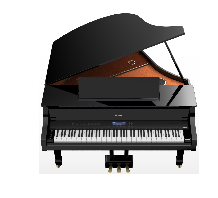

In [27]:
img = open_image('./data/piano3.jpg')
img.show()
learn.predict(img)

In [29]:
learn.predict(data.valid_ds[105][0])

IndexError: list index out of range

In [72]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [73]:
interp.most_confused()

[('desk', 'dresser', 5),
 ('chair', 'table', 3),
 ('glass_box', 'dresser', 3),
 ('mantel', 'range_hood', 3),
 ('mantel', 'tv_stand', 3),
 ('sink', 'tv_stand', 3),
 ('sofa', 'range_hood', 3),
 ('sofa', 'xbox', 3),
 ('tv_stand', 'wardrobe', 3),
 ('bed', 'chair', 2),
 ('bookshelf', 'tv_stand', 2),
 ('cup', 'vase', 2),
 ('glass_box', 'wardrobe', 2),
 ('night_stand', 'tv_stand', 2),
 ('radio', 'night_stand', 2),
 ('radio', 'xbox', 2),
 ('sofa', 'radio', 2),
 ('stairs', 'laptop', 2),
 ('table', 'stool', 2),
 ('tent', 'glass_box', 2),
 ('bathtub', 'cone', 1),
 ('bed', 'desk', 1),
 ('bed', 'door', 1),
 ('bed', 'radio', 1),
 ('bed', 'sofa', 1),
 ('bench', 'piano', 1),
 ('bench', 'table', 1),
 ('bookshelf', 'wardrobe', 1),
 ('bottle', 'car', 1),
 ('bottle', 'vase', 1),
 ('car', 'sofa', 1),
 ('chair', 'airplane', 1),
 ('chair', 'desk', 1),
 ('chair', 'piano', 1),
 ('cone', 'table', 1),
 ('curtain', 'guitar', 1),
 ('dresser', 'cup', 1),
 ('flower_pot', 'chair', 1),
 ('glass_box', 'bookshelf', 1),
